# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

In [10]:
#TODO: Create estimators for your HPs

sagemaker_session = sagemaker.Session()

role = sagemaker.get_execution_role()
bucket = 'sagemaker-us-east-1-297031980234/dogImages'
s3_output_location = f"s3://{bucket}/models/"
objective_metric_name = "test accuracy"
objective_type = "Maximize"
metric_definitions = [{"Name": "test accuracy", "Regex": "Test set: Accuracy: ([0-9\\.]+)"}]

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py3",
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    hyperparameters={"epochs": 1, "backend": "gloo"},
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=9,
    max_parallel_jobs=3,
    objective_type=objective_type,
)

In [11]:
import os
os.environ['SM_MODEL_DIR']=s3_output_location
os.environ['SM_CHANNEL_TRAINING']='s3://sagemaker-us-east-1-297031980234/'

In [6]:
# TODO: Fit your HP Tuner
tuner.fit({"training": "s3://sagemaker-us-east-1-297031980234/"}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...............................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [7]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-09-20 22:25:16 Starting - Found matching resource for reuse
2022-09-20 22:25:16 Downloading - Downloading input data
2022-09-20 22:25:16 Training - Training image download completed. Training in progress.
2022-09-20 22:25:16 Uploading - Uploading generated training model
2022-09-20 22:25:16 Completed - Resource reused by training job: pytorch-training-220920-2152-008-2f5a2ba2


{'_tuning_objective_metric': '"test accuracy"',
 'backend': '"gloo"',
 'batch_size': '"512"',
 'epochs': '1',
 'lr': '0.011217420251214688',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-09-20-21-52-25-796"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-297031980234/pytorch-training-2022-09-20-21-52-25-796/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [14]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing(),
                             rule_parameters={"tensor_regex": "CrossEntropyLoss_output_0",
                                              "num_steps": "5",
                                             "mode": "TRAIN"}),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
#debugger_config = DebuggerHookConfig(
#    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
#)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "5","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)


In [66]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    role=role,
    py_version="py3",
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    hyperparameters={"epochs": 3, "backend": "gloo", 'lr': 0.011217420251214688, 'batch_size': 512},
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

estimator.fit({"training": "s3://sagemaker-us-east-1-297031980234/"})

2022-09-22 05:03:09 Starting - Starting the training job...
2022-09-22 05:03:35 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
ProfilerReport: InProgress
......
2022-09-22 05:04:36 Downloading - Downloading input data...............
2022-09-22 05:07:01 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-09-22 05:06:57,596 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-09-22 05:06:57,598 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2022-09-22 05:06:57,609 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-09-22 05:06:57,616 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-09-22 05:06:58,018 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus instal

In [67]:
# TODO: Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())
print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2022-09-22 05:33:12.311 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-297031980234/pytorch-training-2022-09-22-05-03-08-845/debug-output
['CrossEntropyLoss_output_0']
9
0


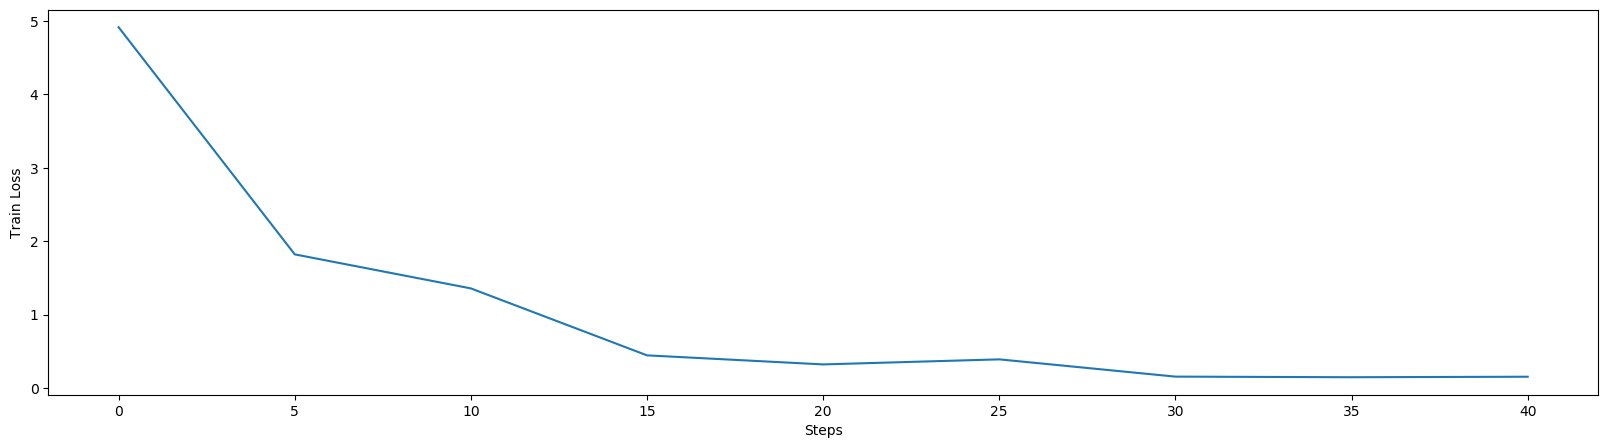

In [68]:
from smdebug import modes
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = 20, 5

plt.ylabel('Train Loss')
plt.xlabel('Steps')
plt.plot(trial.steps(mode=modes.TRAIN),
         list(trial.tensor('CrossEntropyLoss_output_0').values(mode=modes.TRAIN).values()))
plt.show()

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [23]:
# TODO: Display the profiler output
from markupsafe import Markup
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob("pytorch-training-2022-09-21-21-53-39-123", "us-east-1")
tj.wait_for_sys_profiling_data_to_be_available()

ImportError: cannot import name 'Markup' from 'jinja2' (/opt/conda/lib/python3.7/site-packages/jinja2/__init__.py)

## Model Deploying

In [85]:
boto3.client("s3").download_file('sagemaker-us-east-1-297031980234', "pytorch-training-2022-09-22-05-03-08-845/output/model.tar.gz", "model.tar.gz")

In [105]:
import tarfile
  
# open file
file = tarfile.open('model.tar.gz')
file.extractall('./model')
file.close()

In [93]:
import os
import shutil

os.mkdir('model/code/')
shutil.copy('inference.py', './model/code/inference.py')

'./model/code/inference.py'

In [104]:
with tarfile.open('model.tar.gz', "w:gz") as tar:
        for fn in os.listdir('model'):
            p = os.path.join('model', fn)
            tar.add(p, arcname=fn)

In [106]:
boto3.Session().resource('s3').Bucket('sagemaker-us-east-1-297031980234').Object(os.path.join('deploy_model', 'model.tar.gz')).upload_file('model.tar.gz')

In [108]:
from sagemaker.pytorch import PyTorchModel
pytorch_model = PyTorchModel(model_data='s3://sagemaker-us-east-1-297031980234/deploy_model/model.tar.gz', 
                             role=role,
                             py_version="py3",
                             framework_version="1.8.0",
                             entry_point='inference.py')

predictor = pytorch_model.deploy(instance_type='ml.m5.xlarge', initial_instance_count=1)

------------!

In [109]:
# TODO: Run an prediction on the endpoint

from PIL import Image

#transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
#boto3.client("s3").download_file('sagemaker-us-east-1-297031980234', "dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg", "img.png")

image={ "url": "https://s3://sagemaker-us-east-1-297031980234/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg" }

# open it directly
#with Image.open('img.png', mode='r') as f:
    #image = transform(f)
#    response = predictor.predict(image)
#    print(response)

import json
# response = predictor.predict(image)

response=predictor.predict(json.dumps(image), initial_args={"ContentType": "application/json"})
print(response)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2022-09-22-08-29-21-202 in account 297031980234 for more information.

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()